In [1]:
import pickle
from datetime import datetime
import os
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

import numpy as np 
import pandas as pd
import gensim
import nltk.data

from gensim.models import word2vec   # for model training
from gensim.models import Word2Vec   # for model loading

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Read in data
all_data_pkl = open("C:\\Users\\YWang\\Desktop\\plg\\3rd meeting_0908\\all_data.pkl","rb")
all_data = pickle.load(all_data_pkl)
all_data[['call','ex_tag']] = all_data[['call','ex_tag']].astype('int')

data_no_extag = all_data[all_data['ex_tag']==0]
print(data_no_extag.shape)
print("Positive %: ",sum(data_no_extag['call'])/data_no_extag.shape[0])
data_no_extag[:3]

(13418, 4)
Positive %:  0.15270532121


,id,call,ex_tag,txt
0,CTRL000000096,0,0,Subject: FW: Quality Moves to utilize on your ...
1,CTRL000000097,0,0,"Subject: Schedule confirmation From: guzman, M..."
2,CTRL000000099,0,0,"Subject: Emergency Meeting From: ""williams iii..."


## Outline
#### 1.  Attempt to process email text with regular expression pattern match
#### 2.  Preprocess
#### 3.  Compare result
        a. word2vec vs bag-of-word: output improves with more training data?
        b. Upweighing important features

### 1. Attemp to process email text with regular expression pattern match -- TOTALLY FAILED
Special cases:

    FW chain
    RE chain

In [3]:
def get_content(input_str, start_str, end_str, remove_pre_suf_flag = True):
    
    pattern_to_match = start_str + '[\s\S\w\W]+'+ end_str
    matched_str = re.search(pattern_to_match,input_str)
    
    if matched_str is not None:
        # if a pattern match is found
        raw_str = matched_str.group(0)     # this gives you the last match of the end string
        
        # Remove prefix/suffix
        if remove_pre_suf_flag:
            out_str = remove_pre_suf(raw_str, start_str, end_str)
        else:
            out_str = raw_str
        
    else:
        out_str = matched_str
    
    return(out_str)

In [4]:
# Remove prefix/suffix
def remove_pre_suf(input_str, start_str, end_str):
    pattern_to_remove = re.compile(start_str+'|'+end_str)
    out_str = re.sub(pattern_to_remove,'', input_str)
    
    return(out_str)

#### EG

In [70]:
eg = 85 # 1 - a simple email; 22 - a "RE"; 85 - a 'FW'

In [71]:
print(data_no_extag['txt'][eg])
print('\n\n','------------------------------------Processed--------------------------------------------')
print("---->Subject: ")
print(get_content(data_no_extag['txt'][eg], 'Subject:', 'From:'))
print("\n---->From: ")
print(get_content(data_no_extag['txt'][eg], 'From:', 'Date:'))
print("\n---->To: ")
print(get_content(data_no_extag['txt'][eg], 'Date:', 'To:'))
print("\n---->Date: ")
print(get_content(data_no_extag['txt'][eg], 'To:', '\">', False))
print("\n---->Content: ")
print(remove_pre_suf(data_no_extag['txt'][eg],'Subject:[\s\S\w\W]+">', '\*\*[\s\S\w\W]+\*\*'))

Subject: Fw: 5 questions most feared by men are From: "andrea ring" Date: Thu, 05 Apr 2001 23:53:00 +0100 To: "michele winckowski"   ---------------------- Forwarded by Andrea Ring/HOU/ECT on 04/05/2001 03:53 PM ---------------------------    From:  Karen D McIlvoy                           04/05/2001 09:17 AM   To: jadd202@aol.com cc:  (bcc: Andrea Ring/HOU/ECT) Subject: Fw: 5 questions most feared by men are     The 5 questions most feared by men are:  1. What are you thinking about? 2. Do you love me? 3. Do I look fat? 4. Do you think she is prettier than me? 5. What would you do if I died?  What makes these questions so difficult is that every one is guaranteed to explode into a major argument if the man answers incorrectly (i.e., tells the truth). Therefore, as a public service, each question is analyzed below, along with possible responses.  QUESTION #1: WHAT ARE YOU THINKING ABOUT? The proper answer to this, of course, is: "I'm sorry if I've been quiet dear.  I was just reflecti

### 2 Preprocess

#### 2.1 Slightly better way to preprocess data
1. Remove Enron signature
2. Refine removing of html markup
3. Get rid of forward chain

In [251]:
print('--------------------------------Original--------------------------------')
print(data_no_extag['txt'][1])
print()
print('--------------------------------html parser----------------------------------')
print(BeautifulSoup(data_no_extag['txt'][1], "html.parser").get_text())

--------------------------------Original--------------------------------
Subject: Schedule confirmation From: guzman, Mark <"/o=enron/ou=na/cn=recipients/cn=mguzman3"> Date: Mon, 19 Nov 2001 20:54:09 +0000 To: DL-Portland Real Time Shift <"/o=enron/ou=na/cn=recipients/cn=dl-portlandrealtimeshift">   Starting a few days ago, Lotus notes has been eliminated as a format for inputing schedule confirmation and cut schedule information.  The new process is done in Enpower.  Cara sent a notice out last week and I have left a copy of the new process instruction manual on the Real Time desk.  Please take the time to check it out.  For our purposes we will basically only need to read thru the Path Confirmation instructions.  I had a chance to test out this new process a few weeks ago and it is far better than Lotus Notes and works effectively.  If you have any questions feel free to ask Cara or myself.  Thank you for your attention to this matter.  *********** EDRM Enron Email Data Set has been 

In [5]:
def remove_enron_sig(input_str):
    out_str = re.sub('\*\*[\w\W\s\W]+\*\*','',input_str)
    
    return (out_str)

In [6]:
remove_enron_sig(data_no_extag['txt'][1])

'Subject: Schedule confirmation From: guzman, Mark  . To provide attribution, please cite to "ZL Technologies, Inc. (http://www.zlti.com)." ***********'

In [7]:
def remove_html_markup(input_str):
    input_str = input_str.replace("\"",'')
    out_str = BeautifulSoup(input_str, "html.parser").get_text()
    
    return(out_str)

In [ ]:
data_no_extag['txt_2'] = data_no_extag['txt'].map(lambda x: remove_html_markup(remove_enron_sig(x)))

In [ ]:
data_no_extag['txt_2'][1]

#### Roughly remove fw chain

In [250]:
data_no_extag['txt_2'][0]

"Subject: FW: Quality Moves to utilize on your next date From: Alport  Kysa  Date: Thu, 15 Nov 2001 15:26:17 +0000 To: Meyers  Bert     -----Original Message----- From: \tDriscoll, Michael M. Sent:\tWednesday, November 14, 2001 9:03 AM To:\tAlport, Kysa Subject:\tFW: Quality Moves to utilize on your next date    -----Original Message----- From: \tPete Mehok [mailto:pm@navistaff.com] Sent:\tFriday, November 09, 2001 4:11 AM To:\tWalls; Peeps; Scooter; Babar; Blotter; Anthony; Coz; Byrnes; Cibs; Cooter; Doyle; Driscoll, Michael M.; Ferne; Fellrath; Fonz; Gimp; Hoss; Juice; Kiwi; Knute; Klondike; Kuna; Moss; Paps; Rammer; Rosie; Royer; Russ; RyB; Saylor; Scarecrow; Spider; SweetJ; Verlin; ME; Rick Subject:\tQuality Moves to utilize on your next date  God Bless America. If anyone uses one of these moves please report back to me with your results.  I will attempt the Shanghai Shampoo on my date tonight.  HOW TO IMPRESS YOUR GIRLFRIEND These are techniques that have been sent to me by variou

In [13]:
data_no_extag['txt_2'] = data_no_extag['txt_2'].map(lambda x: re.sub('Subject: FW:[\s\S\w\W]+Subject:','Subject:',x))
data_no_extag['txt_2'][0]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


"Subject:\tQuality Moves to utilize on your next date  God Bless America. If anyone uses one of these moves please report back to me with your results.  I will attempt the Shanghai Shampoo on my date tonight.  HOW TO IMPRESS YOUR GIRLFRIEND These are techniques that have been sent to me by various Bunthaus heads. I want to again stress that in no way do we condone the techniques listed here or practice these. Except maybe the Turkey Shoot and the Rear Admiral. And definitely the Spicey Stanley. Here is a fairly extensive compilation of some of the extraordinary sexual activities that can be performed by men: 1. Tea bag - As you are sitting on a girl's face, repeatedly dip your scrotum in and out of her mouth, similar to a tea bag in a cup of hot water. An old favorite. 2. Hot Lunch - While receiving head from a woman, you shit on her chest. (a.k.a. the Cleveland Steamer) 3. The Stranger - Sitting on your hand until it falls asleep and then jerking off, eliciting the feeling of a hand j

#### 2.2. Prepare data for word2vec and bag-of-words
1. bag-of-word: tf-idf
2. word2vec: 500 features; 

     (1) average 
     
     (2) **possibility to up-weigh key words**

In [9]:
# function to preprocess the text of the documents
def txt_to_words(raw_txt, remove_stopwords, join=False):
    
    # Remove non-alphabets and doc starter
    letters_only = re.sub("[^a-zA-Z]", " ", raw_txt).replace(u'\ufeff','')
    
    # To lower case
    letters_only_lower_word_list = letters_only.lower().split()
    
    # Remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        letters_only_lower_word_list = [w for w in letters_only_lower_word_list if not w in stops]
    
    if join:
        return (" ".join(letters_only_lower_word_list))
    else:
        return (letters_only_lower_word_list)

#### bag-of-word prep

In [14]:
data_no_extag['txt_3'] = data_no_extag['txt_2'].map(lambda x: txt_to_words(x,remove_stopwords = False, join = True))

# timing - start
start_time = datetime.today()

# 1. BOW - Frequency count
vectorizer = CountVectorizer(encoding = 'utf-8-sig', stop_words = 'english', 
                             max_df = 0.85, max_features = 5000, ngram_range = (1,1),
                             binary = False)
vectorizer.fit(data_no_extag['txt_3'])
txt_FC = vectorizer.transform(data_no_extag['txt_3'])

# 2. BOW - TF-IDF
tfidf_transformer = TfidfTransformer(sublinear_tf = False, use_idf = True, norm = 'l2')
tfidf_transformer.fit(txt_FC)
txt_TFIDF = tfidf_transformer.transform(txt_FC)

# timing - for both BOW vectorizing and tfidf transformation
t3 = datetime.today() - start_time



# See what's it like
print (txt_TFIDF.shape)
print("TFIDF vectorizing: ", t3)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(13418, 5000)
TFIDF vectorizing:  0:00:38.181186


#### word2vec prep

In [32]:
# function to split a doc into parsed sentences
# returns a list of sentences, where each sentence is a list of words
def doc_to_sentences(txt, tokenizer, remove_stopwords= False):
    
    # 1. Initialize a tokenizer
    paragraph = tokenizer.tokenize(txt.strip())
    
    
    # 2. Parse each sentence into separate words
    sentences = []
    for sentence in paragraph:
        processed_sentence = txt_to_words(sentence, remove_stopwords)
        if len(processed_sentence) > 0:
            sentences.append(processed_sentence)
    
    return sentences

In [310]:
# Use the NLTK tokenizer to split the paragraph into sentences
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# timing
t0 = datetime.today()
sentences = []  # Initialize an empty list of sentences

for txt in data_no_extag['txt_2']:
    sentences += doc_to_sentences(txt, sent_tokenizer)

# timing
print (datetime.today() - t0)

0:02:05.112245


In [315]:
print (len(sentences))  # vs. 1,085,581 sentences
print (sentences[0:3])

807159
[['subject', 'quality', 'moves', 'to', 'utilize', 'on', 'your', 'next', 'date', 'god', 'bless', 'america'], ['if', 'anyone', 'uses', 'one', 'of', 'these', 'moves', 'please', 'report', 'back', 'to', 'me', 'with', 'your', 'results'], ['i', 'will', 'attempt', 'the', 'shanghai', 'shampoo', 'on', 'my', 'date', 'tonight']]


In [329]:
# Set values for various parameters
num_features = 500    # Word vector dimensionality                      
min_word_count = 50   # Minimum word count                        
num_workers = 2       # Number of threads to run in parallel
context = 10          # Context window size
sg = 1                # Default to use CBOW; sg = 1 for skip-gram

# timing
t0 = datetime.today()

model = word2vec.Word2Vec(sentences, 
                          workers = num_workers, 
                          size=num_features, 
                          min_count = min_word_count, 
                          window = context)

# timing
print (datetime.today() - t0)
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

model_name = "sg_500features_50minwords_10context_1005"
model.save(model_name)

0:05:27.194388


In [36]:
# num_features = 500
# Load trained_model
model = Word2Vec.load("sg_500features_50minwords_10context_1005")

# index2word contains all the model vocabulary
print (len(model.index2word))

# syn0 contains vector representation for each word
print (model.syn0.shape)

15735
(15735, 500)


#### Add in the logic to upweight important words

In [49]:
# Function to average all of the word vectors in a doc
def makeFeatureVec(words, model, num_features, 
                   up_weigh, up_weigh_scale, up_weigh_word_list):
    
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,))
    
    # Total words counter
    nwords = 0.
     
    # Convert to set, for speed 
    index2word_set = set(model.index2word)
    
    # Count words in a doc
    # Sum up word vectors for a doc
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            
            # If we want to up-weigh a word that we believe to be important
            if up_weigh and word in up_weigh_word_list:  
                featureVec = np.add(featureVec, model[word]*up_weigh_scale)   
                
            else:
                featureVec = np.add(featureVec,model[word])           
    
    # Calculate average word vector
    # If non of the words in a doc is in the vocabulary, avoid 0 in denominator
    if nwords == 0:
        nwords = 1
        
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [50]:
# Function to loop thru all docs to get average word vector
def getAvgFeatureVecs(docs, model, num_features, up_weigh=False, up_weigh_scale = 1, up_weigh_word_list =[]):
    
    # Initialize a counter
    counter = 0.
    
    # Preallocate 13418 * 300 space for speed
    docsFeatureVecs = np.zeros((len(docs),num_features))
     
    # Loop through the docs
    for doc in docs:
       
       # Print a status message every 1000th review
        if counter%1000. == 0.:
            print ("Doc %d of %d" % (counter, len(docs)))
            
        # calculate feature vector for each doc
        docsFeatureVecs[counter] = makeFeatureVec(doc, model, num_features, up_weigh, up_weigh_scale, up_weigh_word_list)
       
        # Increment the counter
        counter = counter + 1.
    return docsFeatureVecs

#### word2vec - normal version

In [37]:
wordlist_nostop = []

print("---> Parse email text to list of sentence of words, stopwords removed.")
for txt in data_no_extag['txt_2']:
    wordlist_nostop.append(txt_to_words(txt, remove_stopwords=True))
    
print("---> Calculate average word vectors for each documents, no up-weigh.")
wordvec = getAvgFeatureVecs(wordlist_nostop, model, num_features)
wordvec_df = pd.DataFrame(wordvec)

Doc 0 of 13418
Doc 1000 of 13418
Doc 2000 of 13418
Doc 3000 of 13418
Doc 4000 of 13418
Doc 5000 of 13418
Doc 6000 of 13418
Doc 7000 of 13418
Doc 8000 of 13418
Doc 9000 of 13418
Doc 10000 of 13418
Doc 11000 of 13418
Doc 12000 of 13418
Doc 13000 of 13418


In [334]:
wordvec_df.shape

(13418, 500)

#### word2vec - upweighted version

In [59]:
word_i_believe_to_be_important = ['win','winning', 'bet', 'betting','sportsbetting', 'funnymoney', 'casino','nfl','fantasy','football']
upweigh_fold = 20

In [60]:
wordlist_nostop_upweigh = []

print("---> Parse email text to list of sentence of words, stopwords removed.")
for txt in data_no_extag['txt_2']:
    wordlist_nostop_upweigh.append(txt_to_words(txt, remove_stopwords=True))
    
print("---> Calculate average word vectors for each documents, with up-weigh.")
wordvec_upweigh = getAvgFeatureVecs(wordlist_nostop_upweigh, model, num_features,
                                    up_weigh = True, up_weigh_scale = upweigh_fold, up_weigh_word_list = word_i_believe_to_be_important)
wordvec_df_upweigh = pd.DataFrame(wordvec_upweigh)

---> Parse email text to list of sentence of words, stopwords removed.
---> Calculate average word vectors for each documents, with up-weigh.
Doc 0 of 13418
Doc 1000 of 13418
Doc 2000 of 13418
Doc 3000 of 13418
Doc 4000 of 13418
Doc 5000 of 13418
Doc 6000 of 13418
Doc 7000 of 13418
Doc 8000 of 13418
Doc 9000 of 13418
Doc 10000 of 13418
Doc 11000 of 13418
Doc 12000 of 13418
Doc 13000 of 13418


### 3 Comparing result of 3 models

#### 3.1 Output improves with increasing size of training data?
Simple answer:
    1. bag-of-word: yes
    2. word2vec: not as much

In [15]:
# A helper function to get metrics
def get_metrics(y_truth, y_predicted, p_label, return_flag = False):
    confusion_matrix = metrics.confusion_matrix(y_truth, y_predicted, labels = [1,0])
    accuracy = round((metrics.accuracy_score(y_truth, y_predicted)), 2)
    precision = round((metrics.precision_score(y_truth, y_predicted, pos_label = p_label, average = 'binary')), 2)
    recall = round((metrics.recall_score(y_truth, y_predicted, pos_label = p_label, average = 'binary')), 2)
    
    if(return_flag):
        return(pd.DataFrame([accuracy,precision,recall]).transpose())
    else:
        print ("Confusion Matrix:")
        print (confusion_matrix)
        print ()
        print ("Accuracy: %f;\nPrecision: %f;\nRecall: %f;" %(accuracy, precision, recall))

In [28]:
TEST_SIZE = [0.95,0.75,0.5,0.25]

In [55]:
for i in TEST_SIZE:
    X_train, X_test, y_train, y_test = train_test_split(wordvec_df, data_no_extag['call'], test_size = i, random_state = 1)    
    rf = RandomForestClassifier(n_estimators=200, random_state=1)

    rf.fit(X_train, y_train)
    y_pred_w2v = rf.predict(X_test)
    print('\n\n---->Test size: ',i)
    get_metrics(y_test, y_pred_w2v, p_label = 1)



---->Test size:  0.95
Confusion Matrix:
[[  977   980]
 [   17 10774]]

Accuracy: 0.920000;
Precision: 0.980000;
Recall: 0.500000;


---->Test size:  0.75
Confusion Matrix:
[[ 990  549]
 [  23 8502]]

Accuracy: 0.940000;
Precision: 0.980000;
Recall: 0.640000;


---->Test size:  0.5
Confusion Matrix:
[[ 696  322]
 [  19 5672]]

Accuracy: 0.950000;
Precision: 0.970000;
Recall: 0.680000;


---->Test size:  0.25
Confusion Matrix:
[[ 358  134]
 [  14 2849]]

Accuracy: 0.960000;
Precision: 0.960000;
Recall: 0.730000;




---->Test size:  0.95
Confusion Matrix:
[[  924  1033]
 [    5 10786]]

Accuracy: 0.920000;
Precision: 0.990000;
Recall: 0.470000;


<IPython.core.display.Javascript object>


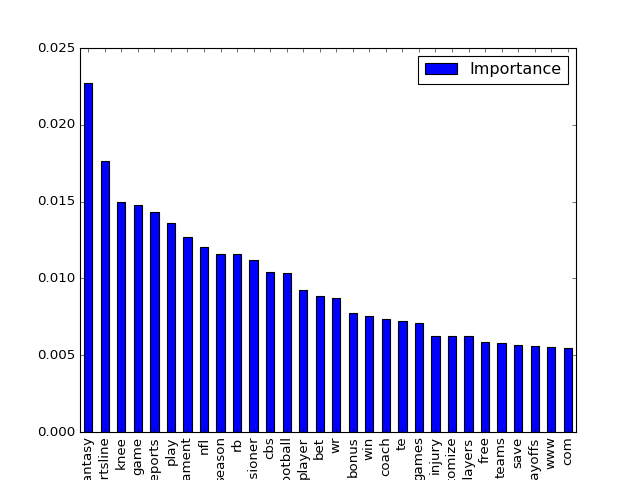



---->Test size:  0.75
Confusion Matrix:
[[1129  410]
 [  22 8503]]

Accuracy: 0.960000;
Precision: 0.980000;
Recall: 0.730000;


---->Test size:  0.5
Confusion Matrix:
[[ 797  221]
 [  23 5668]]

Accuracy: 0.960000;
Precision: 0.970000;
Recall: 0.780000;


---->Test size:  0.25
Confusion Matrix:
[[ 405   87]
 [  13 2850]]

Accuracy: 0.970000;
Precision: 0.970000;
Recall: 0.820000;


<IPython.core.display.Javascript object>


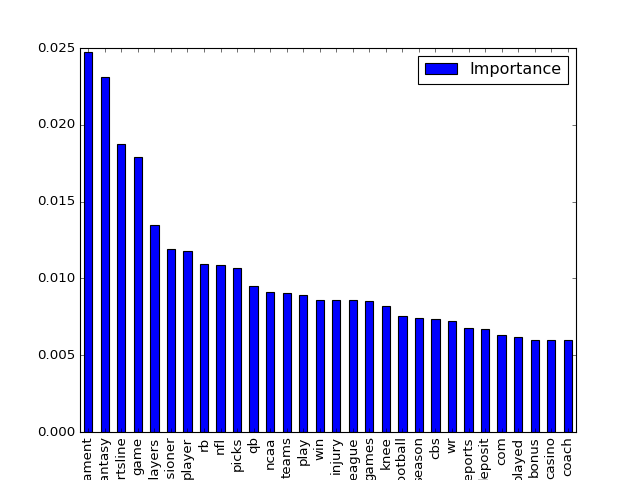

In [29]:
for i in range(len(TEST_SIZE)):
    X_train, X_test, y_train, y_test = train_test_split(txt_TFIDF, data_no_extag['call'], test_size = TEST_SIZE[i], random_state = 1)
    
    rf = RandomForestClassifier(n_estimators=200, random_state=1)

    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print('\n\n---->Test size: ',TEST_SIZE[i])
    get_metrics(y_test, y_pred_rf, p_label = 1)
    
    if i == 0 or i == (len(TEST_SIZE)-1):    
        feature_df = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                                   "Importance": rf.feature_importances_
                                  })
        feature_df.sort_values('Importance', ascending = False)[:30].plot(x = 'Features', y = 'Importance', kind='bar')

#### 3.2 Compare result  for 3 models (test = 0.95)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(txt_TFIDF, data_no_extag['call'], test_size = 0.95, random_state = 1)

rf = RandomForestClassifier(n_estimators=200, random_state=1)

rf.fit(X_train, y_train)

y_pred_rf = pd.DataFrame(rf.predict(X_test), index = y_test.index)
y_prob_rf = pd.DataFrame(rf.predict_proba(X_test), index = y_test.index)
result_rf = pd.merge(y_pred_rf, y_prob_rf, left_index=True, right_index=True)
result_rf.columns = ["rf_Predicted Label", "rf_P(Call=0)", "rf_P(Call=1)"]

get_metrics(y_test,y_pred_rf,p_label=1)

Confusion Matrix:
[[  924  1033]
 [    5 10786]]

Accuracy: 0.920000;
Precision: 0.990000;
Recall: 0.470000;


In [62]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, data_no_extag['call'], test_size = 0.95, random_state = 1)

rf = RandomForestClassifier(n_estimators=200, random_state=1)

rf.fit(X_train, y_train)

y_pred_w2v = pd.DataFrame(rf.predict(X_test), index = y_test.index)
y_prob_w2v = pd.DataFrame(rf.predict_proba(X_test), index = y_test.index)
result_w2v = pd.merge(y_pred_w2v, y_prob_w2v, left_index=True, right_index=True)
result_w2v.columns = ["w2v_Predicted Label", "w2v_P(Call=0)", "w2v_P(Call=1)"]

get_metrics(y_test,y_pred_w2v,p_label=1)

Confusion Matrix:
[[  977   980]
 [   17 10774]]

Accuracy: 0.920000;
Precision: 0.980000;
Recall: 0.500000;


In [65]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df_upweigh, data_no_extag['call'], test_size = 0.95, random_state = 1)

rf = RandomForestClassifier(n_estimators=200, random_state=1)

rf.fit(X_train, y_train)

y_pred_w2v_w = pd.DataFrame(rf.predict(X_test), index = y_test.index)
y_prob_w2v_w  = pd.DataFrame(rf.predict_proba(X_test), index = y_test.index)
result_w2v_w  = pd.merge(y_pred_w2v_w, y_prob_w2v_w, left_index=True, right_index=True)
result_w2v_w.columns = ["w2v_w_Predicted Label", "w2v_w_P(Call=0)", "w2v_w_P(Call=1)"]

get_metrics(y_test,y_pred_w2v_w,p_label=1)

Confusion Matrix:
[[ 1166   791]
 [  123 10668]]

Accuracy: 0.930000;
Precision: 0.900000;
Recall: 0.600000;


In [66]:
temp = pd.concat([result_rf, result_w2v, result_w2v_w],axis = 1)
temp = pd.concat([data_no_extag[['id','txt_2','call']], temp], axis = 1, join = 'outer')

temp.to_csv('output_100516.txt', header = True, index = False, encoding = 'utf-8', sep = "❤")

### TakeAway:
#### 1. Complexity of email text
#### 2. Upweigh keywords

        * Systematic approach (EG Hung's feature selection)
        * Applicable to word2vec/bag-of-word
        
### Next steps:
#### 1. Clustering (similarity; topic modeling)
#### 2. Email text processing